In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os, sys, re
import numpy as np
import random

from collections import defaultdict
from transformers import AutoTokenizer
from datasets import load_dataset
from grader import solution_eq_ans, extract_boxed_answer
from tqdm import tqdm

from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

In [13]:
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")

In [14]:
def apply_problem_template(tokenizer, problem):

    conv = [
        {"role": "user", "content": problem},
    ]

    text = tokenizer.apply_chat_template(conv, tokenize=False, add_generation_prompt=True)
    return text

def apply_template(tokenizer, problem, prefix):

    conv = [
        {"role": "user", "content": problem},
        {"role": "assistant", "content": "<think>\n" + prefix},
    ]

    text = tokenizer.apply_chat_template(conv, tokenize=False, add_generation_prompt=False, continue_final_message=True)
    text += """</think>"""
    return text

In [17]:
output_dir = "/home/myang4/mrt-analysis/outputs/regret"
folders = ["base", "mrt", "grpo"]

In [18]:
math_dataset = load_dataset("hf-cmu-collab/math_reasoning_benchmark", split="AIME2025")
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")

### Load data

In [19]:
for folder in folders:
    data = {}
    for i in range(0, 15, 5):
        with open(os.path.join(output_dir, folder, f'pass_at_k/extrapolate_{i}_{i+5}.pkl'), 'rb') as f:
            data |= pickle.load(f)
    
    with open(os.path.join(output_dir, folder, f'pass_at_k/extrapolate.pkl'), "wb") as f:
        pickle.dump(data, f)

### Compute extrapolation

In [20]:
def compute_extrapolation(extrapolate):
    all_acc = []
    all_flops = []

    for w in tqdm([0, 2, 4, 6, 8]):

        acc = 0
        flops = 0
        
        for n in range(0, 15):
            for rollout in extrapolate[n, w]:
                
                flops += len(tokenizer.encode(rollout.prompt))
                for output in rollout.outputs:
                    acc += solution_eq_ans(rollout.prompt + output.text, str(math_dataset[n]["answer"]))
        
        all_acc.append(acc / 15 / len(extrapolate[n, w]) / len(extrapolate[n, w][0].outputs))
        all_flops.append(flops / 15 / len(extrapolate[n, w]))
    
    return all_acc, all_flops

In [21]:
all_accs = {}
all_flops = {}
for folder in folders:
    with open(os.path.join(output_dir, folder, f'pass_at_k/extrapolate.pkl'), "rb") as f:
        extrapolate = pickle.load(f)
    all_accs[folder], all_flops[folder] = compute_extrapolation(extrapolate)

100%|██████████| 5/5 [00:21<00:00,  4.38s/it]


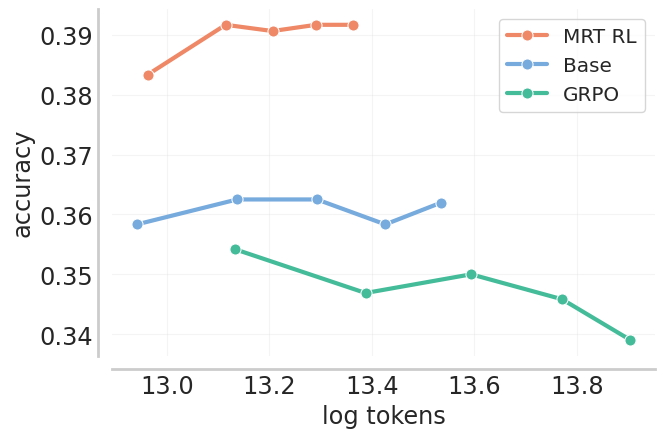

In [22]:
fig, ax = plt.subplots(figsize=(14 / 2, 4.5))

sns.lineplot(x=np.log2(all_flops['mrt']), y=all_accs['mrt'], label='MRT RL', marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[4])
sns.lineplot(x=np.log2(all_flops['base']), y=all_accs['base'], label='Base', marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[1])
sns.lineplot(x=np.log2(all_flops['grpo']), y=all_accs['grpo'], label='GRPO', marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[2])



plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel='log tokens',
                                        ylabel='accuracy',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

plt.show()